In [1]:
%load_ext rpy2.ipython

## Imports

In [1]:
import pandas as pd
import os 
from celloracle import motif_analysis as ma
import pandas as pd
import celloracle as co
import anndata
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


work_dir = '../../output'
celloracle_dir = f'{work_dir}/celloracle'
cicero_dir = f'{work_dir}/cicero'
kaggle_data_dir = '../../input/kaggle/input'
os.makedirs(f'{celloracle_dir}', exist_ok=True)
os.makedirs(f'{cicero_dir}/scATAC', exist_ok=True)
os.makedirs(f'{celloracle_dir}/baseGRN', exist_ok=True)
os.makedirs(f'{celloracle_dir}/GRN', exist_ok=True)

def format_peakname(df):
    df.loc[:, 'location'] = df.location.str.replace(':','_')
    df.loc[:, 'location'] = df.location.str.replace('-','_')
    return  df

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# Cicero

## Format the data 

In [ ]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

In [ ]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
del multiome_train
# extract peaks for donor and cell type
# format and save
df_peaks = format_peakname(df_peaks)
df_peaks[['location','obs_id','count']].to_csv(ff'{work_dir}/cicero/scATAC/peaks.txt', sep='\t', header=None, index=False)

## Annotations

In [3]:
# Get chromosome sizes (for hg38 here). 
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]

chromsizes = chromsizes[['Chromosome', 'End']]
# save
chromsizes.to_csv(f'{work_dir}/cicero/chromsizes.csv', index=False)

In [ ]:
# check if all chr are found
chrs = df_peaks.locations.apply(lambda x:x.split('_')[0])
chrs.isin(chromsizes.Chromosome).sum()

## Actual run

In [ ]:
%%R 
library(Gviz)
library(GenomicRanges)
library(rtracklayer)
library(cicero)
set.seed(2017)
packageVersion("cicero")

# get the peaks
cicero_data <- read.table(paste0("../output/cicero/scATAC/peaks.txt"), sep = "\t", header = FALSE)
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)
input_cds <- monocle3::detect_genes(input_cds)
input_cds <- estimate_size_factors(input_cds)
input_cds <- preprocess_cds(input_cds, method = "LSI")
input_cds <- reduce_dimension(input_cds, reduction_method = 'UMAP', preprocess_method = "LSI")
# reduced dimension and cicero object
umap_coords <- reducedDims(input_cds)$UMAP
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = umap_coords)
# read chromsize
chromsizes <- read.csv(f'{work_dir}/cicero/chromsizes.csv')
# actual run
conns <- run_cicero(cicero_cds, chromsizes)
# save all peaks and connections
all_peaks <- row.names(exprs(input_cds))
write.csv(x = all_peaks, file = "../output/cicero/all_peaks.csv")
write.csv(x = conns, file = "../output/cicero/connections.csv")

# Celloracle

## Base GRN
This section create base GRN given cicero results.
###  Associate peaks with TSS
Each peak is associated with promotors of target genes (+- 1kbp). Celloracle should be installed for this step.

In [51]:
peaks = pd.read_csv(f"{cicero_dir}/all_peaks.csv", index_col=0)
cicero_connections =  pd.read_csv(f"{cicero_dir}/connections.csv", index_col=0)
tss_annotated = ma.get_tss_info(peak_str_list=peaks['x'].values, ref_genome="hg38")
tss_annotated.to_csv(f'{work_dir}/celloracle/baseGRN/tss_annotated.csv')


que bed peaks: 131047
tss peaks in que: 20898


***** WARNING: File /tmp/pybedtools.f78i1zv8.tmp has inconsistent naming convention for record:
GL000194.1	55749	56580

***** WARNING: File /tmp/pybedtools.f78i1zv8.tmp has inconsistent naming convention for record:
GL000194.1	55749	56580



###  Merge TSS peaks with cicero connections

In [81]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)


In [82]:
integrated.to_csv(f'{work_dir}/infer/celloracle/baseGRN/integrated.csv')

###  Shortlisten the peak-gene connections

In [53]:
peak_gene = integrated[integrated.coaccess>0.8].reset_index(drop=True)
peak_gene

,peak_id,gene_short_name,coaccess
0,chr10_100009475_100010367,DNMBP,1.0
1,chr10_100185622_100186542,ERLIN1,1.0
2,chr10_100229082_100229931,CHUK,1.0
3,chr10_100267238_100268104,CWF19L1,1.0
4,chr10_100286187_100287039,BLOC1S2,1.0
...,...,...,...
19109,chrX_9464670_9465539,TBL1X,1.0
19110,chrX_96684366_96685202,DIAPH2,1.0
19111,chrX_97564682_97565222,DIAPH2-AS1,1.0
19112,chrY_13703349_13704256,TMSB4Y,1.0


In [ ]:
peak_gene.to_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv')

### Create base GRN
Running interactively might take a long time.

In [ ]:
# PLEASE make sure reference genome is correct.
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(ref_genome=ref_genome,
                                             genomes_dir=None)
print(ref_genome, "installation: ", genome_installation)

# Instantiate TFinfo object
tfi = ma.TFinfo(peak_data_frame=peak_gene, 
                ref_genome="hg38",
                genomes_dir=None) 

tfi.scan(fpr=0.05, 
         motifs=None,  # If you enter None, default motifs will be loaded.
         verbose=True)
# Check motif scan results
tfi.scanned_df.head()
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

# Format and save 
df = tfi.to_dataframe()
df.head()
df.to_csv(f'{work_dir}/infer/celloracle/baseGRN/grn_celloracle_base.csv')


## Base GRN: only proximal 
This is only based on proximal cis elements and doesnt require cicero

In [54]:
import anndata as ad 
adata_atac = ad.read_h5ad(f'{work_dir}/scATAC/adata_atac.h5ad')

In [55]:
peaks = format_peakname(adata_atac.var.reset_index()).location.values

In [56]:
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38")
tss_annotated.to_csv(f'{work_dir}/infer/celloracle/baseGRN/tss_annotated.csv')

que bed peaks: 135418
tss peaks in que: 21028


***** WARNING: File /tmp/pybedtools.dxm99xoa.tmp has inconsistent naming convention for record:
chr10	100001032	100001800

***** WARNING: File /tmp/pybedtools.dxm99xoa.tmp has inconsistent naming convention for record:
chr10	100001032	100001800



In [77]:
##----- integrate_tss_peak_with_cicero
import numpy as np
from celloracle.motif_analysis.process_bed_file import df_to_list_peakstr
# 1. check tss data format and convert if needed
tss_peak=tss_annotated
tss = tss_peak.copy()
if np.all([i in tss.columns for i in ["chr", "start", "end"]]):
    tss = pd.DataFrame({"peak_id": df_to_list_peakstr(tss),
                        "gene_short_name": tss.gene_short_name.values})
else:
    raise ValueError("tss_peak format error")

peak_gene = tss

In [78]:
peak_gene.to_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv')

### TF motifs

In [5]:
import pandas as pd 
from celloracle import motif_analysis as ma
import genomepy
genomes_dir='/beegfs/desy/user/nourisaj/op_multiomics_grn/output/celloracle'
peak_gene = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv', index_col=0)
genomepy.install_genome(name="hg38", provider="UCSC", genomes_dir=genomes_dir)

In [48]:
# PLEASE make sure reference genome is correct.
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(ref_genome=ref_genome,
                                             genomes_dir=genomes_dir)
print(ref_genome, "installation: ", genome_installation)

# Instantiate TFinfo object
tfi = ma.TFinfo(peak_data_frame=peak_gene, 
                ref_genome="hg38",
                genomes_dir=genomes_dir) 

tfi.scan(fpr=0.05, 
         motifs=None,  # If you enter None, default motifs will be loaded.
         verbose=True)
# Check motif scan results
tfi.scanned_df.head()
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

# Format and save 
df = tfi.to_dataframe()
df.head()
df.to_csv(f'{work_dir}/infer/celloracle/baseGRN/grn_celloracle_base.csv')

## GRN construction


### Preprocessing scRNA-seq

In [86]:
import pandas as pd
import celloracle as co
import anndata
import scanpy as sc
adata = anndata.read_h5ad(f'{work_dir}/scRNA/adata_rna.h5ad')


In [87]:
del adata.varm 
del adata.uns 
del adata.obsp 
del adata.obsm 
del adata.obs['louvain']
adata

AnnData object with n_obs × n_vars = 25551 × 22787
    obs: 'cell_type', 'donor_id', 'n_genes'
    var: 'n_cells'
    layers: 'counts', 'x_norm'

In [88]:
adata.X = adata.layers['counts'].copy()

In [89]:
adata.X.data

array([1., 1., 1., ..., 2., 1., 1.])

In [90]:
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

In [91]:
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

In [95]:
# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [100]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(adata)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [101]:
sc.tl.louvain(adata, resolution=0.8)

In [59]:
adata

AnnData object with n_obs × n_vars = 25551 × 3000
    obs: 'cell_type', 'donor_id', 'n_genes', 'n_counts_all', 'n_counts', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'louvain'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts', 'x_norm'
    obsp: 'distances', 'connectivities'

In [102]:
sc.tl.paga(adata, groups='louvain')

In [103]:
sc.pl.paga(adata)

In [104]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')

In [10]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['cell_type', 'donor_id', 'n_genes', 'louvain', 'n_counts_all', 'n_counts']
Dimensional reduction:  ['X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_umap']


In [108]:
## run based on counts as suggesyed by co pipeline
adata.X = adata.layers["counts"]
adata.X.data

array([1., 1., 1., ..., 1., 1., 2.])

### Load base GRN

In [106]:
base_GRN = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/grn_celloracle_base.csv', index_col=0)

### Initialize 

In [109]:
# Instantiate Oracle object
oracle = co.Oracle()
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cell_type",
                                   embedding_name="X_draw_graph_fr")

In [113]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [114]:
import numpy as np
oracle.perform_PCA()
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

25


In [115]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = min([int(0.025*n_cell), 50])
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

cell number is :25551
Auto-selected k is :50


In [117]:
oracle.to_hdf5(f'{work_dir}/infer/celloracle/grn/presaved_3000.celloracle.oracle')

### GRN calculation


In [ ]:
if True: # run locally
    # Load file.
    oracle = co.load_hdf5(f'{work_dir}/infer/celloracle/grn/presaved_3000.celloracle.oracle')
    # This step may take some time.
    links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10,
                            verbose_level=10)
    links.to_hdf5(file_path=f"{work_dir}/infer/celloracle/grn/links_3000.celloracle.links")
else:
    !python celloracle/run_grn.py

# Post evaluation

## Peak gene connections


In [5]:
tss_annotated = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/tss_annotated.csv')
print(len(tss_annotated))
integrated = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/integrated.csv')
print(len(integrated))
peak_gene_shortlist = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv')
print(len(peak_gene_shortlist))

21028
368203
21028


In [6]:
print('unique peaks in peak-gene', peak_gene_shortlist.peak_id.unique().shape)
print('unique genes in peak-gene', peak_gene_shortlist.gene_short_name.unique().shape)

unique peaks in peak-gene (17295,)
unique genes in peak-gene (16691,)


In [9]:
peak_gene_shortlist = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/peak_gene.csv', index_col=0)
peak_gene_co_n = peak_gene_shortlist.groupby('gene_short_name').apply(lambda df:df['peak_id'].shape[0])
np.max(peak_gene_co_n.values), np.median(peak_gene_co_n.values)

# print('number of TFs ', scenicplus.TF.unique().shape[0], ' CIS ', scenicplus.Region.unique().shape[0], ' gene ', scenicplus.Gene.unique().shape[0])
print('number of DORC genes with t of 10 ', (peak_gene_co_n.values > 10).sum())
print('number of DORC genes with t of 5 ', (peak_gene_co_n.values > 5).sum())

number of DORC genes with t of 10  0
number of DORC genes with t of 5  17


In [ ]:
# convert peak to peak_id using celloracle function
tss_annotated_df = pd.DataFrame({"peak_id": ma.process_bed_file.df_to_list_peakstr(tss_annotated),
                            "gene_short_name": tss_annotated.gene_short_name.values})

In [ ]:
# number of tss_annotated pairs in shortlisted peak
print(f'Percentage of proximal elements in the final peak gene pairs: {100*peak_gene_shortlist.peak_id.isin(tss_annotated_df.peak_id).sum()/len(peak_gene_shortlist)}')

In [ ]:
dorc_shortlisted = peak_gene_shortlist.groupby('gene_short_name').size()
print(f"In the short list: max peaks per gene: {dorc_shortlisted.max()}, median: {dorc_shortlisted.median()}")


In [ ]:
threshold = 10
peak_new = integrated[integrated.coaccess >= threshold]
print('number of DORC: ', (peak_new.groupby('gene_short_name').size()>10).sum())

## Base GRN

In [ ]:
base_GRN = pd.read_csv(f'{work_dir}/infer/celloracle/baseGRN/grn_celloracle_base.csv', index_col=0)

In [ ]:
tfs_co = base_GRN.columns[3:]
keeo_cols = tfs_co.insert(0, ['gene_short_name', 'peak_id'])
df = base_GRN[keeo_cols]
# Melting the DataFrame
melted_df = pd.melt(df, id_vars=['gene_short_name', 'peak_id'], var_name='TF', value_name='Link')

# Filtering out rows where there is no link (optional, if you only want interactions)
melted_df = melted_df[melted_df['Link'] == 1]

In [ ]:
print(f'TFs : {melted_df.TF.unique().shape} , regions : {melted_df.peak_id.unique().shape},  genes : {melted_df.gene_short_name.unique().shape}')

## Refined GRN 

In [3]:
tag = '' #'_hvg'

links = co.load_hdf5(f"{work_dir}/infer/celloracle/grn/links{tag}.celloracle.links") 
links.filter_links(p=0.05, weight="coef_abs")


In [4]:
links_stack = []
cell_types = list(links.links_dict.keys())
links_celltype = links.links_dict[cell_types[2]]
print(f'TFs : {links_celltype.source.unique().shape} , genes : {links_celltype.target.unique().shape}')

TFs : (596,) , genes : (13845,)


In [5]:
top_links = 50_000
grn_stack = []
for i, cell_type in enumerate(cell_types):
    grn_celltype = links.links_dict[cell_type]
    grn_celltype = grn_celltype[~(grn_celltype.coef_mean==0)][['source', 'target', 'coef_mean']] # remove those with 0 coeff
    print('number of links before top quantile selection: ', grn_celltype.shape[0])
    grn_celltype.columns = ['source', 'target', f'weight']
    grn_celltype['cell_type'] = cell_type
    grn_celltype = grn_celltype.sort_values(by='weight', key=abs, ascending=False).head(top_links)
    print('connections: ', grn_celltype.shape)
    print('TFs: ', grn_celltype.source.unique().shape)
    print('target gene: ', grn_celltype.target.unique().shape)
    grn_stack.append(grn_celltype)

number of links before top quantile selection:  2396360
connections:  (50000, 4)
TFs:  (477,)
target gene:  (5885,)
number of links before top quantile selection:  2392742
connections:  (50000, 4)
TFs:  (467,)
target gene:  (6341,)
number of links before top quantile selection:  2388828
connections:  (50000, 4)
TFs:  (460,)
target gene:  (5636,)
number of links before top quantile selection:  2399961
connections:  (50000, 4)
TFs:  (419,)
target gene:  (6973,)


In [6]:
co_grn = pd.concat(grn_stack).reset_index(drop=True)
co_grn

,source,target,weight,cell_type
0,STAT1,RPS26,-0.308208,B cells
1,SPI1,RPS18,0.289873,B cells
2,BCL11B,LEF1,0.289265,B cells
3,SPI1,RPL32,0.284154,B cells
4,STAT1,XIST,-0.278137,B cells
...,...,...,...,...
199995,ETS1,LINC02273,-0.018031,agg_type
199996,EGR1,SRSF3,-0.018030,agg_type
199997,YY1,CYBA,0.018029,agg_type
199998,FOS,PTBP1,0.018029,agg_type


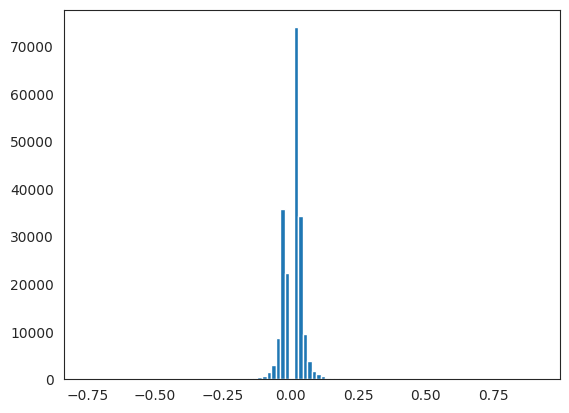

In [8]:
aa = plt.hist(co_grn.weight, bins=100)
plt.show()

In [9]:
co_grn.to_csv(f'{work_dir}/infer/celloracle/grn/co_grn{tag}.csv')